# Pràctica 1: Identificació d'Idioma
**Assignatura:** Processament del Llenguatge Humà (PLH)  
**Model:** Model de llenguatge basat en n-grames de caràcters 

## 1. Introducció
L'objectiu d'aquesta pràctica és construir un classificador automàtic capaç d'assignar un idioma $l_i$ a un document $d$ d'entre un conjunt de 6 llengües europees: alemany (deu), anglès (eng), francès (fra), italià (ita), neerlandès (nld) i castellà (spa).

El sistema es basa en la hipòtesi que les freqüències de certes seqüències de lletres (n-grames) són úniques per a cada idioma. En aquest cas, utilitzarem **trigrammes de caràcters** (n=3).

### Recursos
**Entrenament (Training):** 30.000 frases per idioma del corpus Wortschatz Leipzig.

**Validació (Test):** 10.000 frases per idioma per avaluar la precisió (accuracy) i generar la matriu de confusió.

---

## 2. Pas 1: Preprocessament del Text
El text brut ha de ser normalitzat abans de l'entrenament per evitar biaixos causats per elements no lingüístics. 

### Procediment de neteja:
1. **Eliminar els dígits**: S'eliminen els números del text, ja que no són informatius per identificar l'idioma.
2. **Convertir a minúscula**: Es normalitzen tots els caràcters per reduir la dispersió de dades.
3. **Substitució d'espais**: Es canvien els espais en blanc continus (o tabulacions) per un sol espai.
4. **Unió de frases**: Es concatenen totes les frases del corpus inserint un **espai doble** entre elles.

In [3]:
import re
import os

def preprocess_text(frases):
    """
    Neteja del text:
    - Elimina dígits.
    - Minúscules.
    - Normalitza espais.
    - Concatena amb espai doble al mig, i també a l'inici i al final.
    """
    neteja = []

    for linia in frases:
        # 1. Eliminar els dígits
        text = re.sub(r'\d+', '', linia)
        # 2. Convertir a minúscules 
        text = text.lower()
        # 3. Substituir espais blancs continus per un de sol
        text = re.sub(r'\s+', ' ', text).strip()
        
        if text:
            neteja.append(text)
    
    # 4. Concatena les frases amb un espai doble al mig, a l'inici i al final
    return "  " + "  ".join(neteja) + "  "

# Llista d'idiomes
idiomes = ['deu', 'eng', 'fra', 'ita', 'nld', 'spa'] 

for lang in idiomes:
    for tipus in ['trn', 'tst']:
        nom_fitxer = f"{lang}_{tipus}.txt"
        
        if os.path.exists(nom_fitxer):
            print(f"Processant {nom_fitxer}...")
            with open(nom_fitxer, 'r', encoding='utf-8') as f:
                linies = f.readlines()
            
            text_net = preprocess_text(linies)
            
            # Guardem el resultat en un fitxer nou
            nom_sortida = f"{lang}_{tipus}_clean.txt"
            with open(nom_sortida, 'w', encoding='utf-8') as f_out:
                f_out.write(text_net)
            print(f"Desat: {nom_sortida}")

Processant deu_trn.txt...
Desat: deu_trn_clean.txt
Processant deu_tst.txt...
Desat: deu_tst_clean.txt
Processant eng_trn.txt...
Desat: eng_trn_clean.txt
Processant eng_tst.txt...
Desat: eng_tst_clean.txt
Processant fra_trn.txt...
Desat: fra_trn_clean.txt
Processant fra_tst.txt...
Desat: fra_tst_clean.txt
Processant ita_trn.txt...
Desat: ita_trn_clean.txt
Processant ita_tst.txt...
Desat: ita_tst_clean.txt
Processant nld_trn.txt...
Desat: nld_trn_clean.txt
Processant nld_tst.txt...
Desat: nld_tst_clean.txt
Processant spa_trn.txt...
Desat: spa_trn_clean.txt
Processant spa_tst.txt...
Desat: spa_tst_clean.txt


## 3. Pas 2: Generació del Model i Filtratge amb NLTK

Per a la construcció del model de llenguatge basat en caràcters, utilitzarem la llibreria **NLTK**, concretament la classe `TrigramCollocationFinder`.

### Procediment:
1. **Extracció de Trigrammes de caràcters:** Com que volem un model basat en caràcters, passarem l'string sencer (el text prèviament netejat) a la funció `from_words()`. D'aquesta manera, NLTK tractarà cada lletra i espai com una unitat bàsica, generant seqüències de 3 caràcters (ex: `('c', 'a', 's')`).
2. **Filtratge de freqüències:** Per reduir el soroll estadístic i eliminar combinacions rares o errors, eliminem els trigrammes que apareguin menys de 5 vegades al corpus. Utilitzarem la funció nativa d'NLTK `apply_freq_filter(5)`.
3. **Obtenció del diccionari:** Finalment, extreurem les freqüències filtrades mitjançant l'atribut `ngram_fd`, que ens retorna un diccionari de freqüències (FreqDist) llest per ser utilitzat en el càlcul de probabilitats.

In [4]:
import nltk
from nltk.collocations import TrigramCollocationFinder

# Diccionari global per emmagatzemar la freqüència dels trigrammes de cada idioma
models_entrenament = {}

idiomes = ['deu', 'eng', 'fra', 'ita', 'nld', 'spa']

print("Iniciant la creació dels models de llenguatge...")

for lang in idiomes:
    nom_fitxer_train = f"{lang}_trn_clean.txt"
    
    # Llegim el fitxer de text netejat d'entrenament
    with open(nom_fitxer_train, 'r', encoding='utf-8') as f:
        text_net = f.read()
    
    # 1. Generem els trigrammes de caràcters utilitzant NLTK
    # NLTK genera tuples de 3 caràcters: ex. ('t', 'h', 'e')
    finder = TrigramCollocationFinder.from_words(text_net)
    
    # 2. Apliquem el filtre per eliminar els trigrammes amb freqüència < 5
    finder.apply_freq_filter(5)
    
    # 3. Guardem la distribució de freqüències (FreqDist) al nostre diccionari
    models_entrenament[lang] = finder.ngram_fd
    
    # Imprimim informació per validar que s'ha creat correctament
    num_trigrames = len(models_entrenament[lang])
    print(f"Model per '{lang}' generat amb èxit. Trigrammes únics: {num_trigrames}")

print("\nTots els models d'entrenament han estat generats i emmagatzemats a 'models_entrenament'.")

Iniciant la creació dels models de llenguatge...
Model per 'deu' generat amb èxit. Trigrammes únics: 11321
Model per 'eng' generat amb èxit. Trigrammes únics: 9390
Model per 'fra' generat amb èxit. Trigrammes únics: 10421
Model per 'ita' generat amb èxit. Trigrammes únics: 8325
Model per 'nld' generat amb èxit. Trigrammes únics: 10148
Model per 'spa' generat amb èxit. Trigrammes únics: 9294

Tots els models d'entrenament han estat generats i emmagatzemats a 'models_entrenament'.


## 4. Pas 3: Càlcul de Probabilitats i Tècniques de Suavitzat (Smoothing)

Per calcular la probabilitat que un document de text pertanyi a un idioma determinat, utilitzem un model basat en n-grames assumint independència condicional (enfocament *Naive Bayes*). La probabilitat del document sencer s'estima com el producte de les probabilitats individuals de cada trigramma que el compon.

El problema d'utilitzar l'estimació de Màxima Versemblança (MLE) és la dispersió de dades: assigna una probabilitat de zero als trigrammes no observats durant l'entrenament, la qual cosa anul·la automàticament la probabilitat de tota la frase. Per evitar-ho, utilitzarem i compararem **tres tècniques de suavitzat (smoothing)**.

### 4.1. L'espai mostral i l'estimació de $B$

Abans d'aplicar qualsevol fórmula, cal definir acuradament l'espai mostral. Totes les tècniques necessitaran el paràmetre **$B$**, que representa la mida del vocabulari, és a dir, el nombre de trigrammes *potencialment observables*.

**Per què $B$ ha de ser global i igual per a tots els idiomes?**
Si volem comparar de forma justa $P(text | anglès)$ i $P(text | francès)$ mitjançant un `argmax`, ambdós models han de basar-se en el mateix espai mostral. Si cada idioma tingués la seva pròpia $B$, les probabilitats estarien distribuïdes sobre espais de diferent mida i no serien matemàticament comparables.

**Com estimem $B$?**
Teòricament, $B$ podria ser totes les combinacions matemàtiques possibles de 3 caràcters (ex: $30^3 = 27.000$), però moltes d'aquestes combinacions no existeixen en cap idioma humà. D'altra banda, si calculem $B$ només amb els trigrammes filtrats (freq $\ge 5$), estaríem subestimant la diversitat real de la llengua. 
Per tant, la millor estimació és la **unió de tots els trigrammes únics trobats en els corpus d'entrenament de tots els idiomes ABANS d'aplicar el filtre**. Això ens dona una constant $B$ global, realista i robusta per a totes les fórmules.

---

### 4.2. Les Tres Tècniques de Suavitzat

En tots els models definirem **$N_T$** com la suma total de les freqüències dels trigrammes de l'idioma (després del filtre) i **$c_T(e_j)$** com la freqüència d'un trigramma específic.

#### A) Llei de Lidstone
Aquesta tècnica afegeix una petita quantitat constant $\lambda$ a totes les observacions (vistes i no vistes) per evitar els zeros.

$$P_{LID}(e_j) = \frac{c_T(e_j) + \lambda}{N_T + \lambda \cdot B}$$

El paràmetre $\lambda$ controla quanta "massa de probabilitat" traiem als trigrammes observats per repartir-la entre els desconeguts.

#### B) Descompte Absolut (Absolute Discounting)
En comptes d'afegir probabilitat a tot arreu, aquesta tècnica **resta una quantitat constant $\alpha$** ($0 < \alpha < 1$) a les freqüències dels trigrammes que sí que hem observat. La massa de probabilitat total "robada" és $\alpha \cdot V_T$ (on $V_T$ és el nombre de trigrammes únics de l'idioma). Aquesta massa es reparteix uniformement **només entre els trigrammes que no hem vist mai** (que són exactament $B - V_T$).

* **Si el trigramma s'ha vist ($c_T(e_j) > 0$):**
  $$P_{AD}(e_j) = \frac{c_T(e_j) - \alpha}{N_T}$$

* **Si el trigramma NO s'ha vist ($c_T(e_j) = 0$):**
  $$P_{AD}(e_j) = \frac{\frac{V_T \cdot \alpha}{B - V_T}}{N_T}$$

#### C) Interpolació Lineal (Jelinek-Mercer)
Aquesta tècnica construeix un model més robust combinant (interpolant) la probabilitat del trigrama amb les probabilitats d'ordre inferior (bigrames i unigrames). Si un trigrama no s'ha vist mai, el model es recolza en contextos més curts per no anul·lar la probabilitat.

Donat un trigrama $e_j = (w_{i-2}, w_{i-1}, w_i)$:

$$P_{INT}(d) \approx \lambda_0 \cdot P(w_i, w_{i-1}, w_{i-2}) + \lambda_1 \cdot P(w_i, w_{i-1}) + \lambda_2 \cdot P(w_i)$$

Amb la condició estricta que $\lambda_0 + \lambda_1 + \lambda_2 = 1$. Els paràmetres $\lambda$ indiquen el "pes" que atorguem a cada nivell d'informació (trigrama, bigrama i unigrama respectivament).

---

### 4.3. Selecció del Model via Validació Creuada (Cross-Validation)

Assumir paràmetres a cegues no és rigorós. Per trobar la millor tècnica i el seu hiperparàmetre òptim, implementarem un procés de *Cross-Validation*:

1. **Partició de dades:** Dividirem el corpus d'entrenament mitjançant *Hold-out Validation* (80% per entrenar, 20% per validar).
2. **Entrenament:** Construirem els models de freqüències utilitzant exclusivament el 80% de les dades.
3. **Avaluació (Grid Search):** Avaluarem l'exactitud (*accuracy*) en el 20% de validació provant les 3 tècniques amb diferents bateries de valors per als seus paràmetres ($\lambda$ per Lidstone, $\alpha$ per Descompte Absolut i conjunts de tuples $\lambda_n$ per Interpolació).
4. **Selecció Final:** Ens quedarem amb el mètode i el paràmetre que assoleixi el millor percentatge d'encerts globals per utilitzar-lo, posteriorment, amb les dades de Test.

In [8]:
import math
import nltk
from nltk.collocations import TrigramCollocationFinder

def obtenir_frases_netes(fitxer):
    with open(fitxer, 'r', encoding='utf-8') as f:
        text = f.read()
    return [frase for frase in text.split("  ") if len(frase.strip()) > 0]

# --- 1. SEPARACIÓ I PREPARACIÓ ---
idiomes = ['deu', 'eng', 'fra', 'ita', 'nld', 'spa']

# Guardarem models d'unigrames (1), bigrames (2) i trigrames (3)
models_1_cv, models_2_cv, models_3_cv = {}, {}, {}
N_1_cv, N_2_cv, N_3_cv = {}, {}, {}
V_T_cv = {}
dades_train, dades_val = {}, {}

vocabulari_global_cv = set()

for lang in idiomes:
    frases = obtenir_frases_netes(f"{lang}_trn_clean.txt")
    tall = int(len(frases) * 0.8)
    text_train = "  " + "  ".join(frases[:tall]) + "  "
    
    dades_train[lang] = text_train
    dades_val[lang] = frases[tall:]
    
    # Text com a llista de caràcters per processar fàcilment
    llista_chars = list(text_train)
    
    # Models de Suport (Unigrames i Bigrames)
    models_1_cv[lang] = nltk.FreqDist(llista_chars)
    models_2_cv[lang] = nltk.FreqDist(nltk.ngrams(llista_chars, 2))
    N_1_cv[lang] = len(llista_chars)
    N_2_cv[lang] = len(llista_chars) - 1
    
    # Model Principal (Trigrames)
    finder = TrigramCollocationFinder.from_words(text_train)
    
    # B constant: tots els trigrammes abans de filtrar
    for trigramma in finder.ngram_fd.keys():
        vocabulari_global_cv.add(trigramma)
        
    finder.apply_freq_filter(5)
    model3 = finder.ngram_fd
    
    models_3_cv[lang] = model3
    N_3_cv[lang] = sum(model3.values())
    V_T_cv[lang] = len(model3) # Trigrammes únics (necessari per AD)

B_global = len(vocabulari_global_cv)
print(f"Preparació completada. B Global (Trigrammes únics): {B_global}\n")

# --- 2. FUNCIONS DE PROBABILITAT PER A CADA TÈCNICA ---

def probabilitat_frase(frase, lang, parametre, tecnica):
    finder = TrigramCollocationFinder.from_words("  " + frase + "  ")
    trigs_frase = finder.ngram_fd
    
    # Variables del trigrama
    model3 = models_3_cv[lang]
    N3 = N_3_cv[lang] 
    V = V_T_cv[lang] 
    
    log_p = 0.0
    
    for trig, freq in trigs_frase.items():
        c3 = model3.get(trig, 0)
        
        if tecnica == 'lidstone':
            p = (c3 + parametre) / (N3 + parametre * B_global)
            
        elif tecnica == 'absolute_discounting':
            alpha = parametre
            if c3 == 0:
                p = (V * alpha / (B_global - V)) / N3
            else:
                p = (c3 - alpha) / N3
                
        elif tecnica == 'interpolation':
            l0, l1, l2 = parametre # Desempaquetem la tupla (lambda0, lambda1, lambda2)
            c1, c2, c3_char = trig # (w_{i-2}, w_{i-1}, w_i)
            
            # MLE Trigrama
            p3 = c3 / N3 if N3 > 0 else 0
            # MLE Bigrama (w_{i-1}, w_i)
            p2 = models_2_cv[lang].get((c2, c3_char), 0) / N_2_cv[lang]
            # MLE Unigrama (w_i)
            p1 = models_1_cv[lang].get(c3_char, 0) / N_1_cv[lang]
            
            # Fórmula de la imatge
            p = l0 * p3 + l1 * p2 + l2 * p1
            
            # Evitem el log(0) extrem si el caràcter no existeix en absolut
            if p <= 0:
                p = 1e-10 
            
        log_p += freq * math.log(p)
        
    return log_p

# --- 3. BUCLE D'AVALUACIÓ PER A LES 3 TÈCNIQUES ---

# Per a la interpolació provem tuples (l0, l1, l2) que sumin 1
proves = {
    'lidstone': [0.01, 0.1, 0.25, 0.5, 0.75, 1.0],
    'absolute_discounting': [0.1, 0.5, 0.75, 0.9],
    'interpolation': [
        (0.6, 0.3, 0.1), 
        (0.7, 0.2, 0.1), 
        (0.8, 0.15, 0.05), 
        (0.5, 0.4, 0.1)
    ]
}

resultats_cv = {}

for tecnica, parametres in proves.items():
    print(f"--- Avaluant tècnica: {tecnica.upper()} ---")
    millor_acc_tecnica = 0.0
    millor_param_tecnica = None
    
    for param in parametres:
        encerts = 0
        total_frases = 0
        
        for lang_real, llista_frases in dades_val.items():
            for frase in llista_frases:
                total_frases += 1
                max_prob = -float('inf')
                idioma_predit = None
                
                for lang_model in idiomes:
                    prob = probabilitat_frase(frase, lang_model, param, tecnica)
                    if prob > max_prob:
                        max_prob = prob
                        idioma_predit = lang_model
                
                if idioma_predit == lang_real:
                    encerts += 1
                    
        accuracy = encerts / total_frases
        print(f"  Param={str(param):<15} -> Accuracy: {accuracy:.4f}")
        
        if accuracy > millor_acc_tecnica:
            millor_acc_tecnica = accuracy
            millor_param_tecnica = param
            
    resultats_cv[tecnica] = {'param': millor_param_tecnica, 'acc': millor_acc_tecnica}
    print(f"  >> Guanyador {tecnica}: Param={millor_param_tecnica} (Acc={millor_acc_tecnica:.4f})\n")

# --- 4. RESULTAT FINAL ---
print("=== RESUM FINAL DE VALIDACIÓ ===")
millor_tecnica_global = None
millor_acc_global = 0.0

for tec, res in resultats_cv.items():
    if res['acc'] > millor_acc_global:
        millor_acc_global = res['acc']
        millor_tecnica_global = tec

print(f"\nLA MILLOR TÈCNICA ÉS: {millor_tecnica_global.upper()} amb un accuracy de {millor_acc_global:.4f}")

Preparació completada. B Global (Trigrammes únics): 43798

--- Avaluant tècnica: LIDSTONE ---
  Param=0.01            -> Accuracy: 0.9981
  Param=0.1             -> Accuracy: 0.9982
  Param=0.25            -> Accuracy: 0.9984
  Param=0.5             -> Accuracy: 0.9984
  Param=0.75            -> Accuracy: 0.9985
  Param=1.0             -> Accuracy: 0.9984
  >> Guanyador lidstone: Param=0.75 (Acc=0.9985)

--- Avaluant tècnica: ABSOLUTE_DISCOUNTING ---
  Param=0.1             -> Accuracy: 0.9981
  Param=0.5             -> Accuracy: 0.9982
  Param=0.75            -> Accuracy: 0.9982
  Param=0.9             -> Accuracy: 0.9983
  >> Guanyador absolute_discounting: Param=0.9 (Acc=0.9983)

--- Avaluant tècnica: INTERPOLATION ---
  Param=(0.6, 0.3, 0.1) -> Accuracy: 0.9881
  Param=(0.7, 0.2, 0.1) -> Accuracy: 0.9885
  Param=(0.8, 0.15, 0.05) -> Accuracy: 0.9932
  Param=(0.5, 0.4, 0.1) -> Accuracy: 0.9880
  >> Guanyador interpolation: Param=(0.8, 0.15, 0.05) (Acc=0.9932)

=== RESUM FINAL DE VAL

## 5. Pas 4: Avaluació Final i Matriu de Confusió

Després d'executar la validació creuada sobre el conjunt d'entrenament, hem determinat que la millor tècnica de suavitzat per a les nostres dades és la **Llei de Lidstone amb un paràmetre $\lambda = 0.75$**, assolint una precisió superior al 99.8%.

En aquesta fase final, procedim a avaluar el rendiment real del classificador sobre dades mai vistes.

### 5.1. Entrenament del Model Definitiu
Per aprofitar tot el coneixement disponible, construïm els models de llenguatge definitius utilitzant el **100% del corpus d'entrenament** (`_trn_clean.txt`) per a cada idioma, aplicant el filtre de freqüència $\ge 5$ i calculant la constant global $B$ amb tots els trigrammes previs al filtratge.

### 5.2. Avaluació sobre el Test Set
El conjunt de prova consta de 10.000 frases per idioma (`_tst_clean.txt`). Cada frase serà avaluada pels 6 models d'idioma, i se li assignarà l'idioma que maximitzi la probabilitat (utilitzant la fórmula de Lidstone optimitzada).

### 5.3. Matriu de Confusió
Per entendre millor els errors del model, generarem una **Matriu de Confusió**. Aquesta taula ens permetrà analitzar les classificacions incorrectes i veure si hi ha confusió sistemàtica entre llengües morfològicament properes (com el francès, l'espanyol i l'italià, o l'anglès, l'alemany i el neerlandès).

<>:90: SyntaxWarning: invalid escape sequence '\l'
<>:90: SyntaxWarning: invalid escape sequence '\l'
C:\Users\berta\AppData\Local\Temp\ipykernel_27420\701094638.py:90: SyntaxWarning: invalid escape sequence '\l'
  plt.title(f'Matriu de Confusió (Lidstone $\lambda=0.75$) - Acc: {acc_final:.4f}')


1. Construint els models definitius (100% Train)...
   -> B Global Definitiva: 46939 trigrammes únics.

2. Avaluant sobre el conjunt de Test...

=== RESULTAT FINAL ===
Accuracy en Test: 0.9988 (59906/59977 encerts)


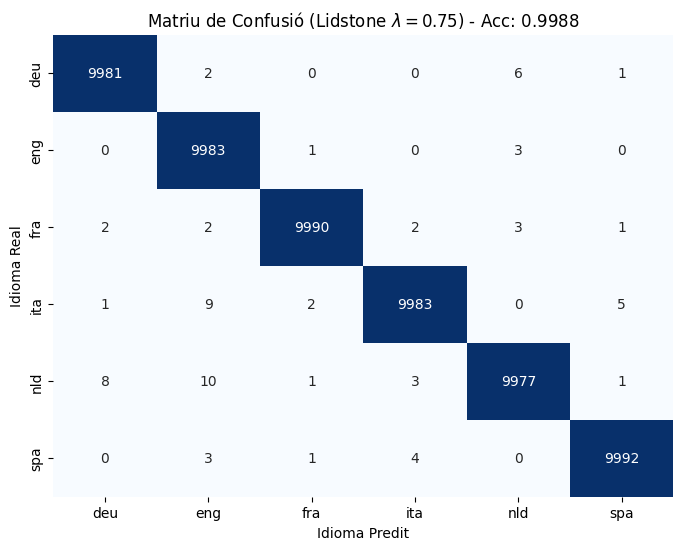


Matriu de Confusió (Text):
      deu   eng   fra   ita   nld   spa
deu  9981     2     0     0     6     1
eng     0  9983     1     0     3     0
fra     2     2  9990     2     3     1
ita     1     9     2  9983     0     5
nld     8    10     1     3  9977     1
spa     0     3     1     4     0  9992


In [4]:
import math
import pandas as pd
from nltk.collocations import TrigramCollocationFinder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def obtenir_frases_netes(fitxer):
    with open(fitxer, 'r', encoding='utf-8') as f:
        text = f.read()
    return [frase for frase in text.split("  ") if len(frase.strip()) > 0]

idiomes = ['deu', 'eng', 'fra', 'ita', 'nld', 'spa']

print("1. Construint els models definitius (100% Train)...")
models_definitius, N_T_def = {}, {}
vocabulari_global_def = set()

for lang in idiomes:
    fitxer_train = f"{lang}_trn_clean.txt"
    with open(fitxer_train, 'r', encoding='utf-8') as f:
        text_complet = f.read()
    
    finder = TrigramCollocationFinder.from_words(text_complet)
    
    # B constant: tots els trigrammes abans de filtrar
    for trigramma in finder.ngram_fd.keys():
        vocabulari_global_def.add(trigramma)
        
    # Apliquem filtre
    finder.apply_freq_filter(5)
    model = finder.ngram_fd
    
    models_definitius[lang] = model
    N_T_def[lang] = sum(model.values())

B_global_def = len(vocabulari_global_def)
print(f"   -> B Global Definitiva: {B_global_def} trigrammes únics.")

# Funció de Lidstone (Guanyadora)
def probabilitat_lidstone(frase, lang, lmbda=0.75):
    finder = TrigramCollocationFinder.from_words("  " + frase + "  ")
    trigs_frase = finder.ngram_fd
    
    model = models_definitius[lang]
    N = N_T_def[lang]
    log_p = 0.0
    
    for trig, freq in trigs_frase.items():
        c = model.get(trig, 0)
        p = (c + lmbda) / (N + lmbda * B_global_def)
        log_p += freq * math.log(p)
        
    return log_p

print("\n2. Avaluant sobre el conjunt de Test...")
y_true = []
y_pred = []

for lang_real in idiomes:
    fitxer_test = f"{lang_real}_tst_clean.txt"
    frases_test = obtenir_frases_netes(fitxer_test)
    
    for frase in frases_test:
        y_true.append(lang_real)
        
        max_prob = -float('inf')
        idioma_predit = None
        
        for lang_model in idiomes:
            prob = probabilitat_lidstone(frase, lang_model, lmbda=0.75)
            if prob > max_prob:
                max_prob = prob
                idioma_predit = lang_model
                
        y_pred.append(idioma_predit)

# --- RESULTATS I MATRIU ---
acc_final = accuracy_score(y_true, y_pred)
print(f"\n=== RESULTAT FINAL ===")
print(f"Accuracy en Test: {acc_final:.4f} ({int(acc_final * len(y_true))}/{len(y_true)} encerts)")

# Generació de la Matriu de Confusió
cm = confusion_matrix(y_true, y_pred, labels=idiomes)
df_cm = pd.DataFrame(cm, index=idiomes, columns=idiomes)

# Mostrar la matriu de forma visual
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Matriu de Confusió (Lidstone $\lambda=0.75$) - Acc: {acc_final:.4f}')
plt.ylabel('Idioma Real')
plt.xlabel('Idioma Predit')
plt.show()

print("\nMatriu de Confusió (Text):")
print(df_cm)